LAI ->> TWDI, span optimizing

In [4]:
%matplotlib inline
import sys
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np
import nlopt
from itertools import product

import os
import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLAgroManagementReader, YAMLCropDataProvider
from pcse.util import WOFOST72SiteDataProvider, DummySoilDataProvider
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
PCSE version: 5.5.0


In [5]:
wdp = NASAPowerWeatherDataProvider(latitude=37, longitude=127)
print(wdp)

# Standard crop parameter library
cropd = YAMLCropDataProvider()
print(cropd)

# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
print(soild)

# Some site parameters
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)
print(sited)

# Package everyting into a single parameter object
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
print(params)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:   47.3
Latitude:  37.000
Longitude: 127.000
Data available for 1984-01-01 - 2021-09-24
Number of missing days: 1

YAMLCropDataProvider - crop and variety not set: no activate crop parameter set!

{'SMFCF': 0.3, 'SM0': 0.4, 'SMW': 0.1, 'RDMSOL': 120, 'CRAIRC': 0.06, 'K0': 10.0, 'SOPE': 10.0, 'KSUB': 10.0}
{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 50.0, 'SMLIM': 0.4, 'CO2': 360.0}
ParameterProvider providing 15 parameters, 0 parameters overridden: dict_keys([]).


In [6]:
agro_yaml = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml)

/tmp/ipykernel_918462/1230033294.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  agro = yaml.load(agro_yaml)


In [7]:
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output())
df.index = pd.to_datetime(df.day)
df.tail()

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,,
2006-10-16,2006-10-16,2.491900,0.575168,17056.442392,11040.695257,2968.840597,3046.906538,2340.016139,0.056159,120.0,0.3,None
2006-10-17,2006-10-17,2.502421,0.558715,17102.193719,11081.871452,2971.128163,3049.194105,2340.949840,0.031452,120.0,0.3,None
2006-10-18,2006-10-18,2.513264,0.560847,17123.517575,11101.062922,2972.194356,3050.260297,2341.385020,0.049498,120.0,0.3,None
2006-10-19,2006-10-19,2.524086,0.550015,17164.097312,11137.584685,2974.223343,3052.289284,2342.213178,0.032433,120.0,0.3,None
2006-10-20,2006-10-20,2.534586,0.530272,17186.531208,11157.775192,2975.345038,3053.410979,2342.671013,0.043408,120.0,0.3,None


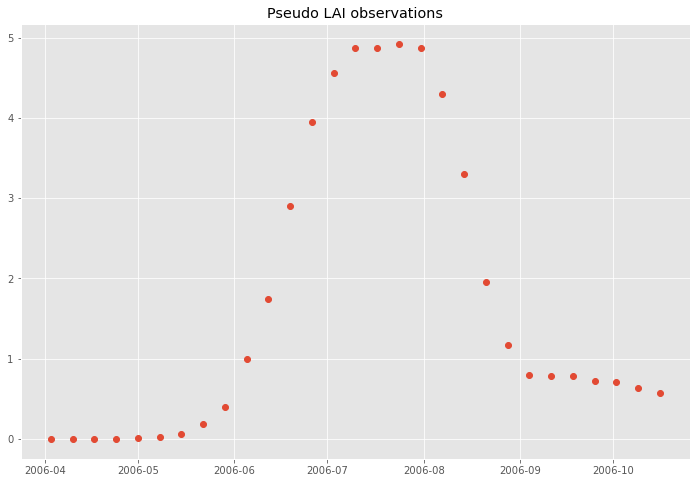

In [8]:
# get daily observations for those
ix = (df.index.dayofweek == 0) & (df.LAI.notnull())
df_pseudo_obs = df.loc[ix]
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI)
r = axes.set_title("Pseudo LAI observations")

In [9]:
class ModelRerunner(object):
    """Reruns a given model with different values of parameters TWDI and SPAN.
    
    Returns a pandas DataFrame with simulation results of the model with given
    parameter values.
    """

    parameters = ["TDWI", "SPAN"]
# sPAN = leaf span of leaves growing at 35celcius, TDWI = initial total crop dry weight
    
    def __init__(self, params, wdp, agro):
        self.params = params
        self.wdp = wdp
        self.agro = agro
# class -> self로 코드 재사용 가능
    def __call__(self, par_values):
        # Check if correct number of parameter values were provided
        if len(par_values) != len(self.parameters):
            msg = "Optimizing %i parameters, but only % values were provided!" % (len(self.parameters, len(par_values)))
            raise RuntimeError(msg)
        # Clear any existing overrides
        self.params.clear_override()
        # Set overrides for the new parameter values
        for parname, value in zip(self.parameters, par_values):
            self.params.set_override(parname, value)
        # Run the model with given parameter values
        wofost = Wofost72_PP(self.params, self.wdp, self.agro)
        wofost.run_till_terminate()
        df = pd.DataFrame(wofost.get_output())
        df.index = pd.to_datetime(df.day)
        return df

In [22]:
class ObjectiveFunctionCalculator(object):
    def __init__(self, params, wdp, agro, observations):
        self.modelrerunner = ModelRerunner(params, wdp, agro)
        self.df_observations = observations
        self.n_calls = 0
       
    def __call__(self, input_params):
        par_values = input_params['TDWI'], input_params['SPAN']
        self.df_simulations = self.modelrerunner(par_values)
        df_differences = self.df_simulations - self.df_observations
        obj_func = np.mean(df_differences.LAI**2) # MSE
        return obj_func

In [23]:
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)

### Hyperopt 사용하기 - 아 이거 아닌거같음

In [24]:
from hyperopt import tpe, hp, fmin
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [25]:
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)

In [26]:
TDWI_range = [0.1, 0.6]
SPAN_range = [30, 40]

In [27]:
space = {
    'TDWI': hp.uniform('TDWI', TDWI_range[0], TDWI_range[1]),
    'SPAN': hp.uniform('SPAN', SPAN_range[0], SPAN_range[1])
}

In [ ]:
best = fmin(
    fn=objfunc_calculator, # Objective Function to optimize
    space=space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=1000 # Number of optimization attempts
)
print(best)

 31%|▌ | 312/1000 [01:24<03:07,  3.67trial/s, best loss: 0.00033166389138789785]

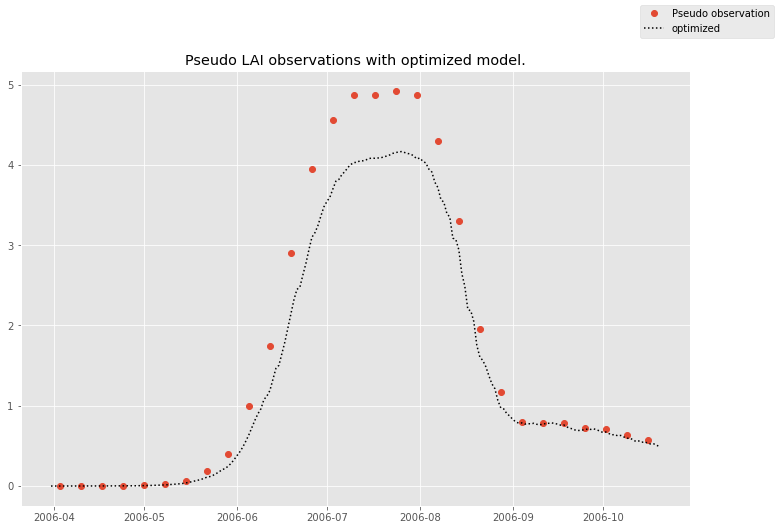

In [33]:
error = objfunc_calculator(best)
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI, label="Pseudo observation")
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.LAI, "k:", label="optimized")
axes.set_title("Pseudo LAI observations with optimized model.")
r = fig.legend()
    